# Bounded Beta Coefficients

Negative values for beta coefficients don't translate into an easily understandable real-world representation.

**Goal**
- Check if bounding the beta coefficients between 0 and 1 impacts
    - Run time
    - Convergence
    - Results as compared to standard Gaussian distribution
    - 

# Inputs

In [50]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import numpy as np
from typing import *

import rnaseq_lib3 as r

In [3]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt_centered.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

# Sample and Training Genes

Select n-of-1

In [32]:
classes = normal.tissue.unique()

In [27]:
sample = tumor.loc['TCGA-KK-A7B2-01']
sample.tissue

'Prostate'

Select gene training set

In [29]:
genes = df.columns[5:]
training_genes = r.outlier.select_k_best_genes(normal, genes, 'tissue', 50)
training_genes += ['ARAF', 'PARP1']

# LogitNormal
Try logitnormal, bounded between 0 and 1
## Model Definition

In [116]:
def run_model0(sample: pd.Series,
              background_df: pd.DataFrame,
              class_col: str,
              training_genes: List[str] = None,
              gene_pool: List[str] = None,
              n_genes: int = 50,
              draws: int = 500,
              tune: int = 1000,
              n_chains: int = 4):
    """
    Run Bayesian outlier model

    Args:
        sample: N-of-1 sample to run   
        background_df: Background dataframe to use in comparison
        class_col: Column in background dataframe to use as categorical discriminator
        training_genes: Genes to use during training
        gene_pool: Set of genes
        n_genes: Number of genes to use in training if not supplied via training_genes
        draws: Number of draws during sampling
        tune: Sampling parameter
        n_chains: Sampling parameter

    Returns:
        Model and Trace from PyMC3
    """
    assert any([gene_pool, training_genes]), 'gene_pool or training_genes must be supplied'

    # Create categorical index
    idx = background_df[class_col].astype('category').cat.codes
    n_cats = len(background_df[class_col].unique())

    # Identify gene set to train on
    if not training_genes:
        training_genes = select_k_best_genes(background_df, genes=gene_pool, class_col=class_col, n=n_genes)

    # Define model and sample
    with pm.Model() as model:
        # Alpha in linear model
        a = pm.Normal('a', mu=0, sd=10)

        # If number of categories is 1, we don't need hyperpriors for b
        if n_cats == 1:
            b = pm.Normal('b', mu=0, sd=10, shape=1)
        else:
            mu_b = pm.Normal('mu_b', mu=0, sd=10)
            sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
            b = pm.LogitNormal('b', mu=mu_b, sd=sigma_b, shape=n_cats)

        # Linear model
        mu = {}
        for gene in training_genes:
            mu[gene] = a + b[idx] * background_df[gene]

        # Model estimation
        eps = pm.InverseGamma('eps', 2.1, 1)
        z = {}
        for gene in training_genes:
            z[gene] = pm.Laplace(gene, mu=mu[gene], b=eps, observed=sample[gene])

        trace = pm.sample(draws=draws, tune=tune, n_chains=n_chains)
    return model, trace

## Run Model

In [117]:
m0, t0 = run_model0(sample, normal, 'tissue', training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [13:42<00:00,  4.25draws/s] 
The number of effective samples is smaller than 25% for some parameters.


## TracePlot

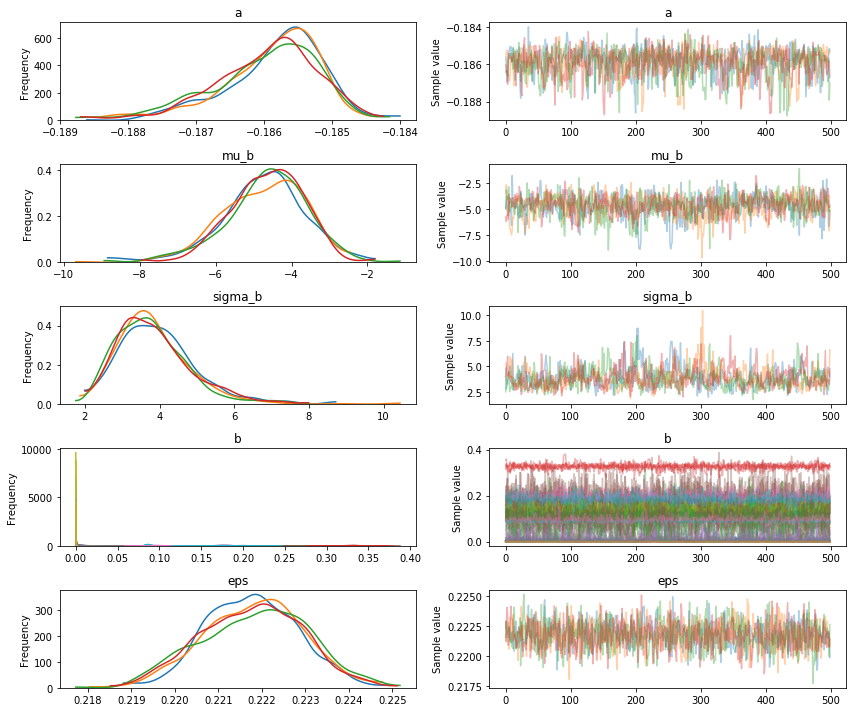

In [118]:
pm.traceplot(t0);

## Weights

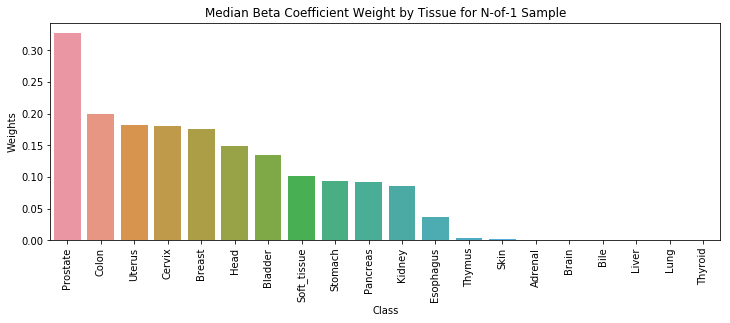

In [119]:
r.outlier.plot_weights(classes, t0);

## PPC

In [120]:
ppc0 = pm.sample_ppc(trace=t0, model=m0);

100%|██████████| 500/500 [00:23<00:00, 21.00it/s]


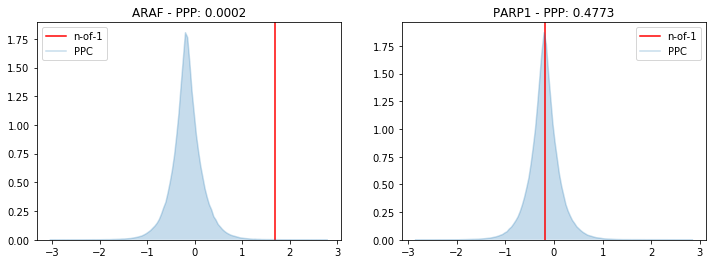

In [122]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, gene in enumerate(['ARAF', 'PARP1']):
    z = ppc0[gene].ravel()
    z_true = sample[gene]
    ppp = round(sum(z_true < z) / len(z), 4)

    ax[i].axvline(z_true, label='n-of-1', c='r')
    sns.kdeplot(z, label='PPC', ax=ax[i], shade=True, alpha=0.25)
    ax[i].set_title(f'{gene} - PPP: {ppp}');

## Linear Model Estimation

TODO: Create dimensions similar to `sample_ppc`

In [137]:
ppc0['ARAF'].shape

(500, 726)

In [127]:
z = t0['a']
for i, t in enumerate(classes):
    samples = np.random.choice(normal[normal['tissue'] == t]['ARAF'], len(z))
    z += t0['b'][:, i] * samples

In [128]:
z = st.laplace.rvs(loc=z, scale=t0['eps'], size=(1000, 2000)).ravel()

In [129]:
z_true = sample['ARAF']
ppp = round(sum(z_true < z) / len(z), 4)

Text(0.5, 1.0, '0.0014')

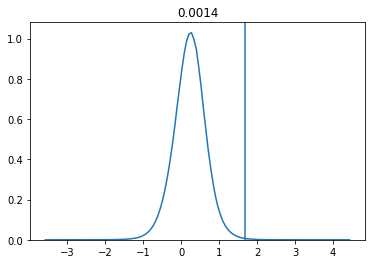

In [130]:
plt.axvline(z_true)
sns.kdeplot(z)
plt.title(f'{ppp}')

# Standard Gaussian

To compare logitnormal to

## Run Model

In [131]:
m1, t1 = r.outlier.run_model(sample, normal, 'tissue', training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [10:07<00:00,  8.44draws/s] 


## TracePlot

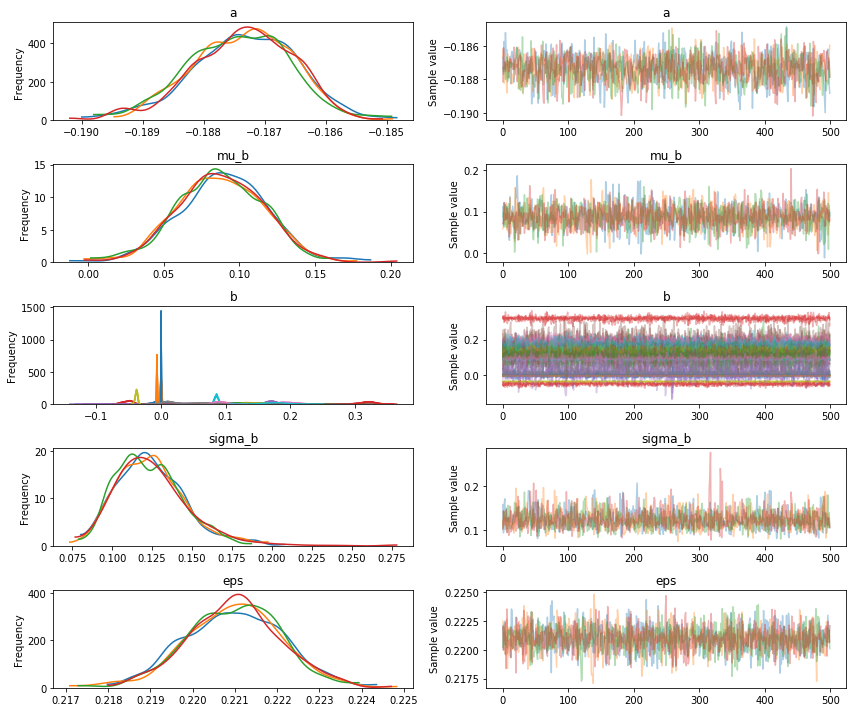

In [132]:
pm.traceplot(t1);

## Weights

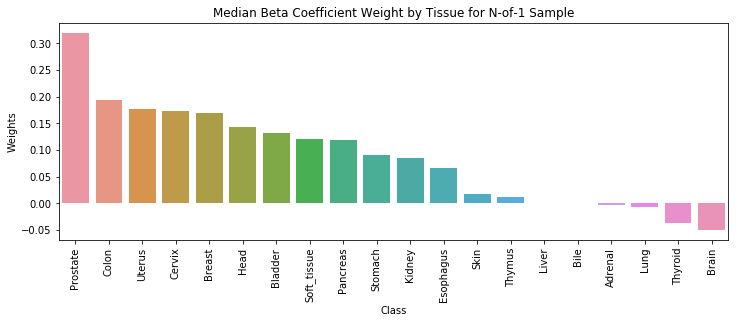

In [133]:
r.outlier.plot_weights(classes, t1);

## PPC

In [134]:
ppc1 = pm.sample_ppc(trace=t1, model=m1)

100%|██████████| 500/500 [00:21<00:00, 23.50it/s]


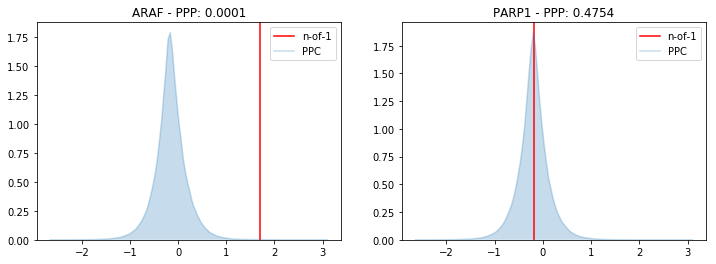

In [135]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, gene in enumerate(['ARAF', 'PARP1']):
    z = ppc1[gene].ravel()
    z_true = sample[gene]
    ppp = round(sum(z_true < z) / len(z), 4)

    ax[i].axvline(z_true, label='n-of-1', c='r')
    sns.kdeplot(z, label='PPC', ax=ax[i], shade=True, alpha=0.25)
    ax[i].set_title(f'{gene} - PPP: {ppp}');

# LogitNormal with Different Sample

In [138]:
sample = tumor.loc['TCGA-CJ-4916-01']

In [139]:
m2, t2 = run_model0(sample, normal, 'tissue', training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [10:51<00:00,  4.36draws/s] 
The number of effective samples is smaller than 25% for some parameters.


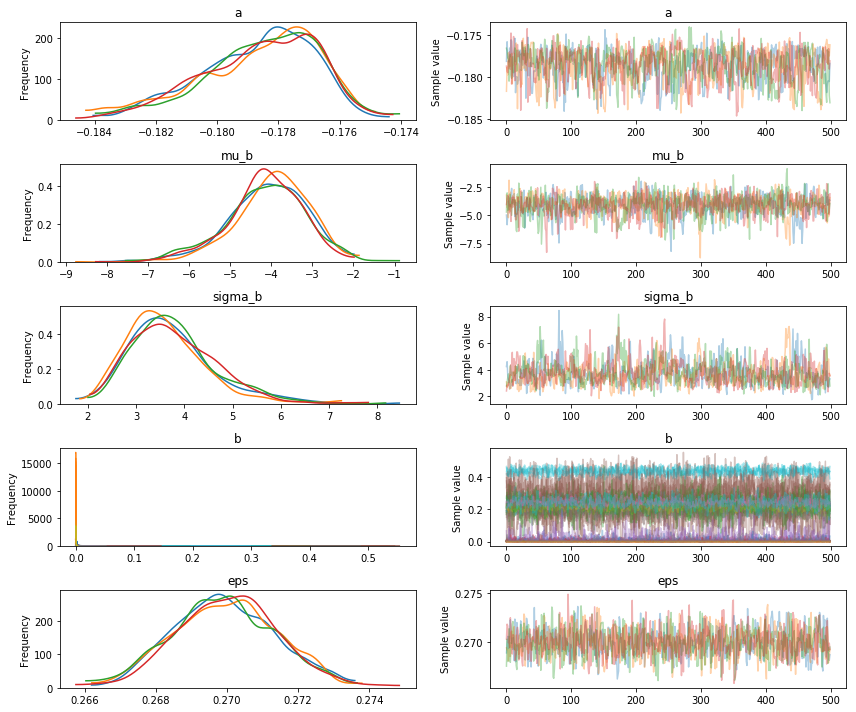

In [140]:
pm.traceplot(t2);

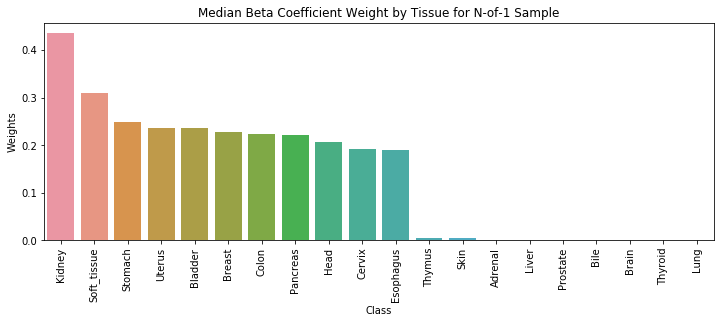

In [141]:
r.outlier.plot_weights(classes, t2);

In [142]:
ppc2 = pm.sample_ppc(trace=t2, model=m2);

100%|██████████| 500/500 [00:24<00:00, 20.48it/s]


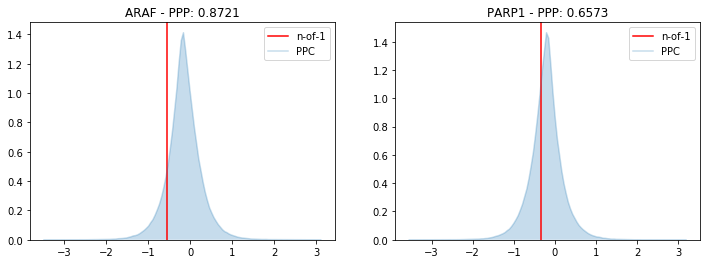

In [146]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, gene in enumerate(['ARAF', 'PARP1']):
    z = ppc2[gene].ravel()
    z_true = sample[gene]
    ppp = round(sum(z_true < z) / len(z), 4)

    ax[i].axvline(z_true, label='n-of-1', c='r')
    sns.kdeplot(z, label='PPC', ax=ax[i], shade=True, alpha=0.25)
    ax[i].set_title(f'{gene} - PPP: {ppp}');